In [1]:
pip install pandas pandas-ta backtesting matplotlib

  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached Backtesting-0.3.3.tar.gz (175 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218924 sha256=31be98ad26829360e81ab9d5c63335f7d78028ce8adecb2a5ed5f5c2b335801a
  Stored in directory: c:\users\vaibhav\appdata\local\pip\cache\wheels\7f\33\8b\50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173970 sha256=0f2b26dba6c0157d5a8183c4564dc2ee6111d55868c43cdd02d3114938fac94f
  Stored in directory: c:\users\vaibhav\appdata\local\pip\cache\wheels\2c\56\19\bf7ee5e164aa99a976e3f64841c83b5ae0391c59d9aec011d0
Successfully built pandas-ta backtesting
Note: you may need to restart the kernel to use updated packages.


C:\Users\Vaibhav\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 5400 configurations.
  output = _optimize_grid()


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\Vaibhav\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Vaibhav\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


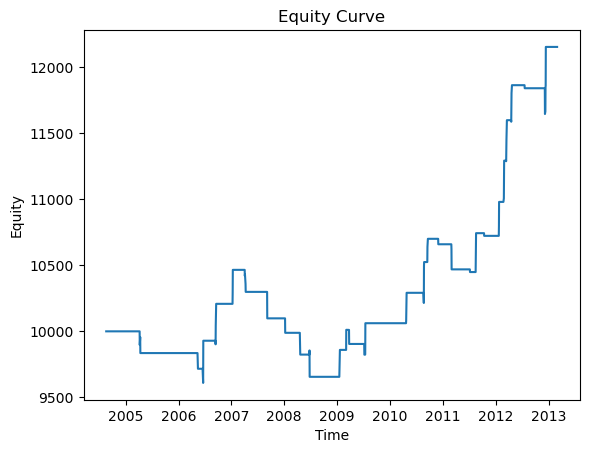

In [10]:
import pandas as pd
import pandas_ta as ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG  
import matplotlib.pyplot as plt

# Ensure GOOG data has a DatetimeIndex for time-based trading strategies & Sort by datetime to avoid any index issues
GOOG.index = pd.to_datetime(GOOG.index)
GOOG = GOOG.sort_index()  

# EMA-VWAP trading strategy
class EMAVWAPStrategy(Strategy):
    # Default parameters for EMAs, VWAP, stop-loss, and take-profit
    short_ema_period = 8
    long_ema_period = 21
    trend_ema_period = 55
    sl_pct = 0.5  #  Setting Stop-loss percentage
    tp_pct = 1.5  # Take-profit percentage

    def init(self):
        # Calculate EMAs
        self.short_ema = self.I(ta.ema, pd.Series(self.data.Close), self.short_ema_period)
        self.long_ema = self.I(ta.ema, pd.Series(self.data.Close), self.long_ema_period)
        self.trend_ema = self.I(ta.ema, pd.Series(self.data.Close), self.trend_ema_period)

        # Calculate VWAP using high, low, close, and volume
        self.vwap = self.I(
            ta.vwap, 
            pd.Series(self.data.High, index=self.data.df.index), 
            pd.Series(self.data.Low, index=self.data.df.index), 
            pd.Series(self.data.Close, index=self.data.df.index), 
            pd.Series(self.data.Volume, index=self.data.df.index)
        )

    def next(self):
        price = self.data.Close[-1]

        # Close all positions at the end of the trading day
        if self.data.index[-1].time() >= pd.Timestamp("15:30").time():
            self.position.close()
            return

        # Determine trade direction based on EMA and VWAP
        if price > self.trend_ema[-1]:  # Uptrend
            if crossover(self.short_ema, self.long_ema) and price > self.vwap[-1]:
                self.buy(sl=(1 - self.sl_pct / 100) * price, tp=(1 + self.tp_pct / 100) * price)
        
        # Downtrend
        elif price < self.trend_ema[-1]: 
            if crossover(self.long_ema, self.short_ema) and price < self.vwap[-1]:
                self.sell(sl=(1 + self.sl_pct / 100) * price, tp=(1 - self.tp_pct / 100) * price)


bt = Backtest(GOOG, EMAVWAPStrategy, cash=10_000, commission=.002)
stats = bt.optimize(
    short_ema_period=range(5, 15, 1),
    long_ema_period=range(15, 30, 1),
    trend_ema_period=range(50, 70, 5),
    sl_pct=[0.5, 1.0, 1.5],  # Optimize stop-loss percentages
    tp_pct=[1.5, 2.0, 2.5],  # Optimize take-profit percentages
    maximize='Sharpe Ratio',
    constraint=lambda param: param.short_ema_period < param.long_ema_period < param.trend_ema_period
)


bt.plot()

plt.plot(stats['_equity_curve']['Equity'])
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.show()


In [4]:

GOOG.index = pd.to_datetime(GOOG.index)

In [12]:
print(stats.keys())

Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Return [%]', 'Buy & Hold Return [%]',
       'Return (Ann.) [%]', 'Volatility (Ann.) [%]', 'Sharpe Ratio',
       'Sortino Ratio', 'Calmar Ratio', 'Max. Drawdown [%]',
       'Avg. Drawdown [%]', 'Max. Drawdown Duration', 'Avg. Drawdown Duration',
       '# Trades', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]',
       'Avg. Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration',
       'Profit Factor', 'Expectancy [%]', 'SQN', '_strategy', '_equity_curve',
       '_trades'],
      dtype='object')


In [13]:
# key performance metrics
print("Sharpe Ratio:", stats.get('Sharpe Ratio', 'N/A'))
print("Total Return [%]:", stats.get('Return [%]', 'N/A'))
print("Max Drawdown [%]:", stats.get('Max. Drawdown [%]', 'N/A'))  
print("Win Rate [%]:", stats.get('Win Rate [%]', 'N/A'))
print("Total Trades:", stats.get('# Trades', 'N/A'))
print("Avg Trade [%]:", stats.get('Avg. Trade [%]', 'N/A'))


Sharpe Ratio: 0.6756413867105485
Total Return [%]: 21.510950399999913
Max Drawdown [%]: -7.73054425992955
Win Rate [%]: 51.724137931034484
Total Trades: 29
Avg Trade [%]: 0.6851375935917892
